# Laboratorio 2 - Informe

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## 1. Objetivos
El objetivo de este laboratorio es:
- Implementar el algoritmo Naive Bayes
- Aplicar herramientas de metodología
- Analizar los resultados obtenidos.

## 2. Diseño
### 2.1 Algoritmo

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate

DATASET_FILE = "./lab1_dataset.csv"
dataset = pd.read_csv(DATASET_FILE, sep=",")
target = 'cid'
continuous_features = [
    'time',
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
features = [
    'time', 
    'trt', 
    'age', 
    'wtkg', 
    'hemo', 
    'homo', 
    'drugs', 
    'karnof',
    'oprior', 
    'z30', 
    'zprior', 
    'preanti', 
    'race', 
    'gender', 
    'str2', 
    'strat',
    'symptom', 
    'treat', 
    'offtrt', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
dataset = dataset.drop(['pidnum'], axis=1)

,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,0,948,2,48,89.8128,0,0,0,100,0,...,0,0,1,0,1,0,422,477,566,324
1,1,1002,3,61,49.4424,0,0,0,90,0,...,0,1,3,0,1,0,162,218,392,564
2,0,961,3,45,88.4520,0,1,1,90,0,...,1,1,3,0,1,1,326,274,2063,1893
3,0,1166,3,47,85.2768,0,1,0,100,0,...,1,1,3,0,1,0,287,394,1590,966
4,0,1090,0,43,66.6792,0,1,0,100,0,...,1,1,3,0,0,0,504,353,870,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,0,1091,3,21,53.2980,1,0,0,100,0,...,1,1,3,0,1,1,152,109,561,720
2135,0,395,0,17,102.9672,1,0,0,100,0,...,1,1,3,0,0,1,373,218,1759,1030
2136,0,1104,2,53,69.8544,1,1,0,90,0,...,1,1,3,0,1,0,419,364,1391,1041
2137,1,465,0,14,60.0000,1,0,0,100,0,...,1,0,1,0,0,0,166,169,999,1838


### Implementación de Naive-Bayes

In [2]:
def naive_bayes(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    product_1 = prob_1
    product_0 = prob_0
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # product of sequence
        product_1 *= ( numerator_1 / (dataset[target].value_counts()[1] + m) )
        product_0 *= ( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (product_0/(product_0 + product_1), product_1/(product_0 + product_1))

Naive-Bayes es un método de inferir las probabilidades de pertenencia de una instancia a una clase. Para lograr esto, se asumen independientes los atributos lo que facilitan el calculo. Para cada atributo, se estima la probabilidad condicional de que una instancia pertenezca a una clase específica, dado el valor del atributo. Dada la asuncion anterior, estas probabilidades se definen como:

$$P((a_1,a_2,...,a_n) | H) = P(a_1|H)\cdot ... \cdot P(a_n|H)$$

A continuación, se detalla nuestra implementación de este algoritmo.

Nuestra implementación del algoritmo recibe cinco parámetros. En orden se recibe el conjunto de datos (dataset), la columna objetivo (target), los atributos (features), la instancia que se desea predecir (instance), y el hiperparámetro m.

Se comienza calculando las probabilidades previas para las clases 0 y 1. Posteriormente, para cada atributo, se estima la probabilidad condicional de que se pertenezca a cada clase objetivo según el valor del atributo en la instancia a predecir. En este cálculo se utiliza el m-estimador para no dar probabilidad 0 a valores que no se observaron, aumentando el tamaño de la muestra con más ejemplos distribuidos según la probabilidad previa de tener este valor.
$$\text{m-estimador}: \frac{e + m\cdot p}{n+m}$$
Donde e son los ejemplos, m el hiperparametro, p la probabilidad previa de tener el valor y n el tamanio del conjunto de datos

Finalmente, utilizando el producto de las probabilidades condicionales acumuladas, se obtiene la probabilidad total de que la instancia pertenezca a la clase 0 o 1. Es importante notar que nuestra implementación no realiza la clasificación final, sino que devuelve un par de probabilidades. La primera representa la probabilidad de que la instancia pertenezca a la clase 0 y la segunda que pertenezca a la clase 1.

### Implementación de Naive-Bayes logarítmico

In [3]:
def naive_bayes_log(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    sum_1 = np.log(prob_1)
    sum_0 = np.log(prob_0)
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # sum of sequence
        sum_1 += np.log( numerator_1 / (dataset[target].value_counts()[1] + m) )
        sum_0 += np.log( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (np.exp(sum_0)/(np.exp(sum_0) + np.exp(sum_1)), np.exp(sum_1)/(np.exp(sum_0) + np.exp(sum_1)))

In [4]:
class CustomNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, features, m):
        self.features = features
        self.m = m

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_train[target] = y_train
        return self

    def predict(self, X_test):
        y_pred = []
        for i in range(0, X_test.shape[0]):
            instance = X_test.iloc[i]
            prob_0, prob_1 = naive_bayes_log(self.X_train, target, self.features, instance, self.m)
            if (prob_0 > prob_1):
                y_pred.append(0)
            else:
                y_pred.append(1)
        return np.array(y_pred)
    
    
    def __sklearn_clone__(self):
        return self

Por qué determinamos esta clase (representación interna de implementación de cross validation de scikit)

Además de la implementacion de naive-Bayes mediante probabilidades, se implemento la variación de naive-Bayes logarítmico. En esta variante, en vez de trabajar con las probabilidades, se utilizan sus logaritmos, lo que amplía el rango de valores, reduce el riesgo de inestabilidades numéricas y convierte productos en sumas. Debido a esta última propiedad, el calculo del producto de las probabilidades condicionales se intercambia por la sumatoria de probabilidades logarítmicas. Para el resultado devuelto se deshace la conversión logaritmica con el propósito de obtener las probabilidades. Aun así, los logaritmos preservan el orden relativo entre los valores (a < b si y sólo si ln(a) < ln(b)).

Con el propósito de utilizar la función de validación cruzada de sk-learn, se creó una clase `CustomNaiveBayes`. Esta función `cross_validate` requiere de un objeto que represente al estimador e implemente una función llamada `fit` asi como la funcion `predict`


### 2.3 Evaluación

Explicar métricas de evaluación que vamos a usar (accuracy, recall, precision, f1_score) y por qué usamos average weighted de cada métrica (dataset desbalanceado).

## 3. Experimentación

### 3.1 Evaluación del hiperparametro m

In [5]:

# Initialize KBinsDiscretizer for continuous features
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

# Discretize continuous features
dataset[continuous_features] = kbins.fit_transform(dataset[continuous_features])

# Prepare X and y
X = dataset.drop(target, axis=1)
y = dataset[target]

# List of m values
m_values = [1, 10, 100, 1000]

results = pd.DataFrame(columns=['m', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Iterate over m values
for m in m_values:
    model = CustomNaiveBayes(features, m)
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted','f1_weighted'] )
    results.loc[results.shape[0]] = [m, scores['test_accuracy'].mean(), scores['test_precision_weighted'].mean(), scores['test_recall_weighted'].mean(), scores['test_f1_weighted'].mean()]

print(f"{results}\n")



        m  Accuracy  Precision    Recall        F1
0     1.0  0.840559   0.838707  0.840559  0.839194
1    10.0  0.841028   0.839491  0.841028  0.839759
2   100.0  0.836358   0.830394  0.836358  0.831376
3  1000.0  0.770452   0.765621  0.770452  0.694210



Hablar de preprocesamiento: KBins discretizer, por qué usamos kmeans para strategy\
Explicar el experimento (cross validation)\
Explicar resultados obtenidos (mejor m=10)

### 3.2 Evaluación de feature selection

In [6]:

results = pd.DataFrame(columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for k in range(1,24):
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    
    train_ds = X_train[selected_features].copy()
    train_ds[target] = y_train
    
    y_pred = []
    
    for i in range(0, X_test.shape[0]):
        instance = X_test.iloc[i]
        prob_0, prob_1 = naive_bayes_log(train_ds, target, selected_features, instance, 10)
        if (prob_0 > prob_1):
            y_pred.append(0)
        else:
            y_pred.append(1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.loc[results.shape[0]] = [k, accuracy, precision, recall, f1]
    
print(results)

/home/francisco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


       k  Accuracy  Precision    Recall        F1
0    1.0  0.740654   0.548569  0.740654  0.630302
1    2.0  0.764019   0.848525  0.764019  0.778354
2    3.0  0.808411   0.853692  0.808411  0.818235
3    4.0  0.799065   0.821060  0.799065  0.806036
4    5.0  0.820093   0.843570  0.820093  0.826795
5    6.0  0.813084   0.836067  0.813084  0.819890
6    7.0  0.817757   0.842262  0.817757  0.824696
7    8.0  0.829439   0.850645  0.829439  0.835504
8    9.0  0.820093   0.841812  0.820093  0.826491
9   10.0  0.820093   0.838426  0.820093  0.825846
10  11.0  0.822430   0.841471  0.822430  0.828272
11  12.0  0.808411   0.835286  0.808411  0.816011
12  13.0  0.817757   0.838740  0.817757  0.824079
13  14.0  0.824766   0.842859  0.824766  0.830370
14  15.0  0.827103   0.844263  0.827103  0.832469
15  16.0  0.827103   0.844263  0.827103  0.832469
16  17.0  0.831776   0.848702  0.831776  0.836997
17  18.0  0.829439   0.847293  0.829439  0.834893
18  19.0  0.829439   0.847293  0.829439  0.834893


Explicar por arriba chi2, por qué usamos chi2\
Explicar evaluacion de feature selection, explicar experimento en gral (rango de k, pq incluimos 23 = sin feature selection)\
Explicar resultados obtenidos (mejor k = 3), indicando que vale la pena hacer feature selection

In [7]:
selector = SelectKBest(chi2, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

chi2_scores = selector.scores_

feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Chi2_Score': chi2_scores,
})

feature_scores_sorted = feature_scores.sort_values(by='Chi2_Score', ascending=False)
print(feature_scores_sorted)


    Feature     Chi2_Score
0    pidnum  135844.595104
1      time     287.311524
21    cd420     129.950143
20     cd40      28.592771
12  preanti      27.492696
17  symptom      21.059162
2       trt      13.135860
16    strat       9.025053
10      z30       8.650495
18    treat       8.618287
8    karnof       8.289357
19   offtrt       8.086323
15     str2       7.772575
22     cd80       5.292697
13     race       5.222743
7     drugs       4.539810
3       age       2.095679
9    oprior       1.313644
6      homo       1.201686
14   gender       0.245730
4      wtkg       0.096075
23    cd820       0.073067
5      hemo       0.002447
11   zprior       0.000000



Confusion Matrix:
[[249  68]
 [ 14  97]]




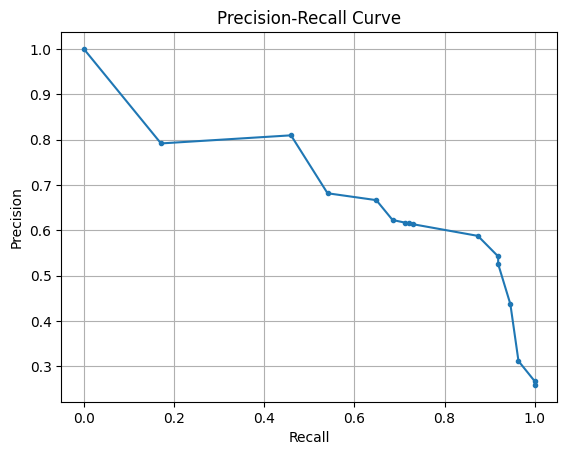

Area Under Curve: 0.710842151129899



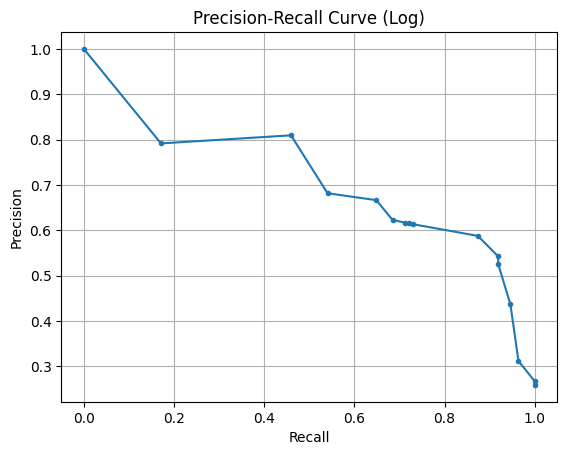

Area Under Curve (Log): 0.710842151129899



In [8]:
selector = SelectKBest(chi2, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

y_score = []
y_score_log = []
y_pred = []

for i in range(0, X_test.shape[0]):
    instance = X_test.iloc[i]
    prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
    prob_log_0, prob_log_1 = naive_bayes_log(train_ds, target, selected_features, instance, 10)
    y_score.append(prob_1)
    y_score_log.append(prob_log_1)
    if (prob_0 > prob_1):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_score)
precision_log, recall_log, thresholds_log = precision_recall_curve(y_true=y_test, y_score=y_score_log)

area_under_curve = auc(recall, precision)
area_under_curve_log = auc(recall_log, precision_log)

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n\n")

plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

print(f"Area Under Curve: {area_under_curve}\n")

plt.plot(recall_log, precision_log, marker='.')
plt.title('Precision-Recall Curve (Log)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

print(f"Area Under Curve (Log): {area_under_curve_log}\n")

Mencionar adaptación que hicimos a la implementación para bancar esto (hacer exponencial de las probs logaritimicas en la implementacion)\
No hay diferencias entre graficas, explicar por qué pasa esto (si fueran más atributos capaz habrían más problemas por la representacion interna de los datos, multiplicacion de numeros cada vez mas cicos en implementacion sin logariimos)\
(Opcional) Graficar matriz de confusion

### Comparar con lab anterior